In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [3]:
pip install tensorflow

In [29]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=15

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data",
   batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    
)

Found 4188 files belonging to 4 classes.


In [6]:
class_names=dataset.class_names


In [7]:
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [8]:
len(dataset)

131

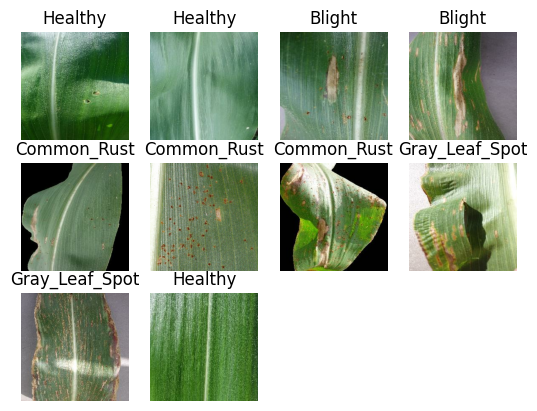

In [9]:
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        axes=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
train_size=0.8
len(dataset)*train_size

104.80000000000001

In [11]:
train_ds=dataset.take(104)
len(train_ds)

104

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=15)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [21]:
len(train_ds)


104

In [22]:
len(val_ds)


13

In [23]:
len(test_ds)

14

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
104/104 [==============================] - 262s 2s/step - loss: 0.7864 - accuracy: 0.6623 - val_loss: 0.5080 - val_accuracy: 0.7933
Epoch 2/15
104/104 [==============================] - 220s 2s/step - loss: 0.4498 - accuracy: 0.8248 - val_loss: 0.4501 - val_accuracy: 0.7861
Epoch 3/15
104/104 [==============================] - 261s 2s/step - loss: 0.4182 - accuracy: 0.8290 - val_loss: 0.4056 - val_accuracy: 0.8365
Epoch 4/15
104/104 [==============================] - 302s 3s/step - loss: 0.3584 - accuracy: 0.8510 - val_loss: 0.3789 - val_accuracy: 0.8221
Epoch 5/15
104/104 [==============================] - 247s 2s/step - loss: 0.3621 - accuracy: 0.8510 - val_loss: 0.5365 - val_accuracy: 0.8101
Epoch 6/15
104/104 [==============================] - 257s 2s/step - loss: 0.3472 - accuracy: 0.8594 - val_loss: 0.3354 - val_accuracy: 0.8582
Epoch 7/15
104/104 [==============================] - 235s 2s/step - loss: 0.3301 - accuracy: 0.8582 - val_loss: 0.3239 - val_accuracy: 0.8486

In [36]:

 scores = model.evaluate(test_ds)

    

14/14 [==============================] - 14s 355ms/step - loss: 0.2752 - accuracy: 0.8884


actual label: Blight
1/1 [==============================] - 0s 348ms/step
predicted label: Blight


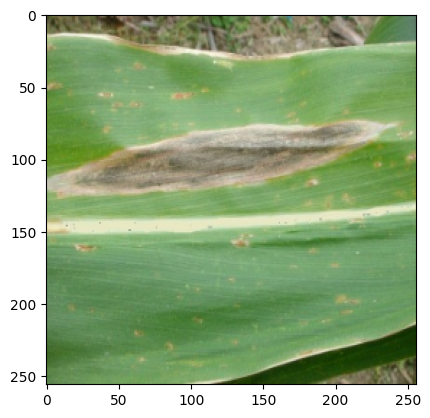

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 59ms/step


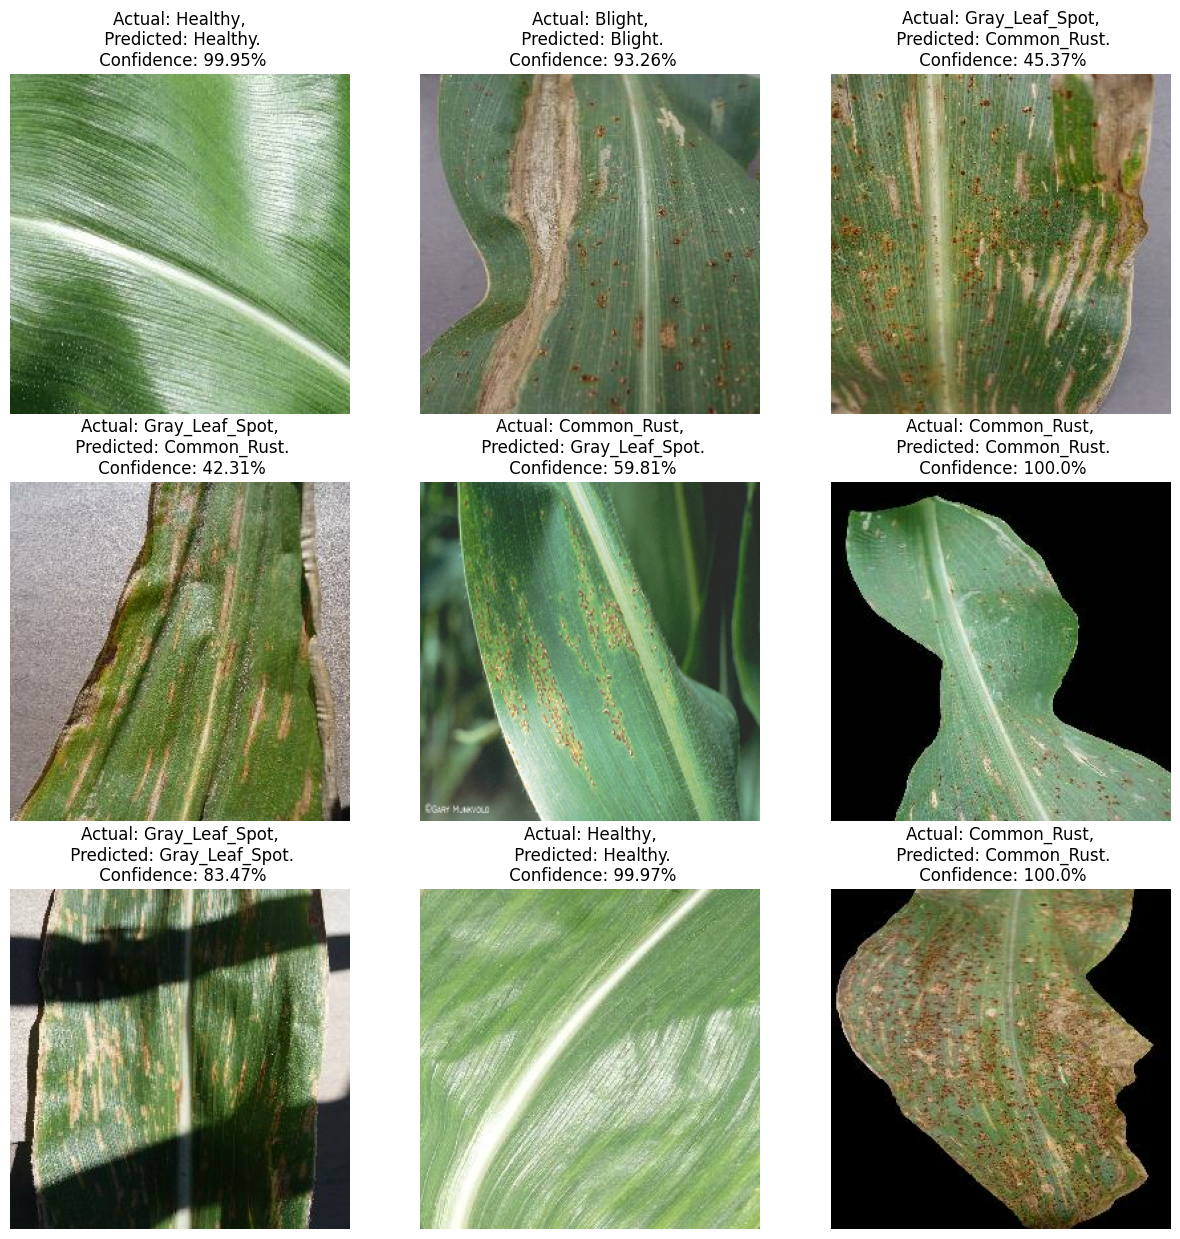

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")